In [98]:
import numpy as np
import torch 

import matplotlib.pyplot as plt
%matplotlib inline

import torch, torch.nn as nn

import time 
from IPython import  display

# Dataset

In [99]:
def f(x, a, w, b):
    return a[0]*np.sin(w[0]*x+b[0])+a[1]*np.sin(2*w[1]*x+b[1])

In [100]:
def generate_dataset(N, Size=None):
    """N - number of datasets to be generated"""
    param_set = {'w':[], 'a':[], 'b':[], 'mu_x':[]}
    datasets = []
    for i in range(N):
        if Size is None:
            Size = np.random.randint(low=4, high=50)
        w = np.random.uniform(low=5, high=7, size=2)
        b = np.random.uniform(low=0, high=2*np.pi, size=2)
        a = np.random.normal(loc=0, scale=1.0, size=2)
        mu_x = np.random.uniform(low=-4, high=4, size=1)

        param_set['w'].append(w); param_set['b'].append(b); param_set['a'].append(a); param_set['mu_x'].append(mu_x); 
        
        x = np.random.normal(loc=mu_x, scale=1.0, size=Size)
        y = np.random.normal(loc=f(x, a, w, b), scale=0, size=Size)
    
        datasets.append((x, y))
        
    return datasets, param_set

In [101]:
def iterate_minibatches(datasets, batchsize):
    """iterate between datasets with defined batchsize"""
    for ind, d in enumerate(datasets):
        indices = np.random.permutation(np.arange(len(d[0])))
        for start in range(0, len(indices), batchsize):
            ix = indices[start: start + batchsize]
            
            yield  ind, torch.FloatTensor(d[0][ix]).unsqueeze(1), torch.FloatTensor(d[1][ix]).unsqueeze(1), len(d[0])

# Model

In [102]:
class fc_block(nn.Module):
    def __init__(self, dim_in, dim_out):
        
        super(fc_block, self).__init__()
        self.fc = nn.Sequential(nn.Linear(dim_in, dim_out), 
                                nn.LayerNorm(dim_out),
                                nn.ReLU())
                                
    def forward(self, C):

        return self.fc(C) 

class Decoder(nn.Module):
    def __init__(self, in_z, in_x, dim_middle, dim_out, n_layers):
        """ 
        nn that maps from latent space Z and the sample X to the target variable Y
        
        """
        super(Decoder, self).__init__()
        
#         in_z = 0
        self.fc0 = nn.Linear(in_z+in_x, dim_middle) 
        self.fc1 = fc_block(dim_middle, dim_middle)
                
        self.layer_stack = nn.ModuleList([
            fc_block(dim_middle, dim_middle)
            for _ in range(n_layers)])
        
        self.fc_last_mu = nn.Linear(dim_middle, dim_out)
        self.fc_last_sigma = nn.Linear(dim_middle, dim_out)

        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
    
 
    def forward(self, X, z):
        """
        takes x and latent z and produces target y
        """
  
        c = torch.cat([X, z], dim=-1)
#         c = X
        if verbose: print('c', c.shape)
        c = self.relu(self.fc0(c))
    
        c, c_prev = self.fc1(c), c
        if verbose: print('c', c.shape)

        for fc in self.layer_stack:
            c, c_prev = fc(c+c_prev), c

        if verbose: print('c', c.shape)
            
        self.mu_y = self.fc_last_mu(c)
        self.sigma_y = self.sigmoid(self.fc_last_sigma(c))*0.1+0.001


        return self.mu_y, self.sigma_y
    


In [103]:
class Encoder(nn.Module):
    def __init__(self, dim_in, dim_middle, dim_out, n_layers):
        """ 
        nn that maps dataset to the latent z that represent it      
        """
        super(Encoder, self).__init__()
        
        # пока самая простая 
        self.fc1 = nn.Linear(dim_in, dim_middle)
        self.relu = nn.ReLU()
        
        self.layer_stack = nn.ModuleList([
            fc_block(dim_middle, dim_middle)
            for _ in range(n_layers)])
            
        self.fc_last_mu = nn.Linear(dim_middle, dim_out)
        self.fc_last_sigma = nn.Linear(dim_middle, dim_out)
        
 
    def forward(self, S):
        """
        takes dataset S and produces mu and sigma of normal distribution z
        """

        S = self.relu(self.fc1(S))  
        S_prev = S
        
        for fc in self.layer_stack:
            S, S_prev = fc(S+S_prev), S
            
        if verbose: print('S', S.shape)
        S = S.mean(0)
        
        self.mu_z = self.fc_last_mu(S)
        self.s = self.fc_last_sigma(S)
        self.sigma_z = self.s.exp() # экспонента чтобы не было отрицательных значений дисперсии

        return self.mu_z, self.sigma_z, self.s
    


$$\ln p(D) \ge \sum_j E_{N(z | 0, 1)} \sum_i \ln p(y_{ij} | x_{ij}, h_\alpha(\mu_z+\Sigma_z^{1/2} z)) - \sum_j KL(q_{\theta_j}(z_j, S_j) || p(z_j)) $$

${KL({\mathcal {N}}_{0}\|{\mathcal {N}}_{1})={1 \over 2}\left\{\operatorname {tr} \left({\boldsymbol {\Sigma }}_{1}^{-1}{\boldsymbol {\Sigma }}_{0}\right)+\left({\boldsymbol {\mu }}_{1}-{\boldsymbol {\mu }}_{0}\right)^{\rm {T}}{\boldsymbol {\Sigma }}_{1}^{-1}({\boldsymbol {\mu }}_{1}-{\boldsymbol {\mu }}_{0})-k+\ln {|{\boldsymbol {\Sigma }}_{1}| \over |{\boldsymbol {\Sigma }}_{0}|}\right\},}$

$$\Sigma_0 = \Sigma_z \\ 
\mu_0 = \mu_z, \\ 
\Sigma_1 = I, \\ 
\mu_1 = 0$$

$$KL(q_{\theta_j}(z_j, S_j) || p(z_j))= \frac 1 2 ( \sum_i \sigma_i + \mu_z^T\mu_z - 2D -\sum_i\ln{\sigma_i}) $$


In [104]:
class DeepPrior(nn.Module):
    def __init__(self, in_x, in_z, dim_middle, dim_out, n_enc_layers, n_dec_layers):
        
        super(DeepPrior, self).__init__()
    
        self.dim_z = in_z
        
        in_y = 1
        self.in_z = in_z
        
        self.encoder = Encoder(in_x+in_y, self.in_z, self.in_z, n_enc_layers)
        self.decoder = Decoder(in_z, in_x, dim_middle, dim_out, n_dec_layers)
        
        self.ELBO = {}
 
    def forward(self, ind, X, y, l):
        """
        takes dataset S and produces ELBO lower bound for p(D) where D - dataset
        """
        
        # now let compute stohastic part
        S = torch.cat([X, y], dim = -1)
        if verbose: print('S', S.shape)
        mu_z, sigma_z, _  = self.encoder(S)
        if verbose: print('mu_z, sigma_z', mu_z.shape, sigma_z.shape)
        sigma_z = sigma_z.pow(1/2)
   
        # firstly let compute not stochastic component that corresponds to KL term
        KL_part = -1/2 * (sigma_z.sum()+(mu_z*mu_z).sum() - 2*self.dim_z - sigma_z.log().sum())
        
        if verbose: print('KL_part', KL_part)
            
        #sampling
        N_batch = S.shape[0]
        z = torch.normal(mean = torch.zeros((1, self.in_z)), 
                          std = torch.ones((1,  self.in_z)))
        
        z = z.repeat(N_batch, 1)
        
        if verbose: print('z', z.shape)
            
        z = mu_z+sigma_z*z
        if verbose: print('z', z.shape)
        mu_y, sigma_y = self.decoder(X, z)
        
        if verbose: print('mu_y, sigma_y', mu_y.shape, sigma_y.shape)
        
        
        log_likelihood = -1/2*(y - mu_y)*(y-mu_y)/ sigma_y.pow(2)
        if verbose: print('log_likelihood', log_likelihood.shape) 
            
        log_likelihood = log_likelihood.sum()-sigma_y.log().sum()
        if verbose: print('log_likelihood', log_likelihood.shape)

        ratio = float(np.max([l/N_batch, 1]))
        loss = ratio*log_likelihood+KL_part
        
        l_np = float(loss.cpu().data.numpy())
#         print('l_np',l_np)
        try:
            self.ELBO[ind].append(l_np)
        except KeyError:
            self.ELBO[ind]=[l_np]

        
        return -loss
    
    def predict(self, X, y, X_pred):
        """
        S - dataset (tuple with two tensors with shape (Points, 1))
        X - points to predict y in (tensor with shape (N_points, ))
        """
        
        S = torch.cat([X, y], dim = -1)
        if verbose: print('S', S.shape)
        mu_z, sigma_z, _  = self.encoder(S)
        
#         sigma_z = sigma_z.pow(1/2)
#         N_batch = 1
#         z = torch.normal(mean = torch.zeros((N_batch, self.in_z)), 
#                           std = torch.ones((N_batch,  self.in_z)))      
#         if verbose: print('z', z.shape)
            
        z = mu_z.unsqueeze(0) #+sigma_z*z
        if verbose: print('z', z.shape)
            
        z = z.repeat(X_pred.shape[0], 1)
        if verbose: 
            print('z', z.shape)
            print('X', X.shape)
            
        mu_y, sigma_y = self.decoder(X_pred, z)
        
        return mu_y, sigma_y

        

# Training

In [140]:
def train_model(model, num_epochs=20, batchsize = 10, verbose=True, plot_every = 100):
    
    start_time = 0
    
    for epoch in range(num_epochs):
        model.train(True) # enable dropout / batch_norm training behavior
        for (ind, X_batch, y_batch, l) in iterate_minibatches(datasets, batchsize):
            
#             print('ind', ind)
            loss, log_likelihood, flow_loss, prior_loss, z0_loss = model(ind, torch.Tensor(X_batch), torch.Tensor(y_batch), l)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm(model.parameters(), 0.25)
            optimizer.step()
            optimizer.zero_grad()
            
            if ind==0:
                X_0 = X_batch
                y_0 = y_batch


        # Visualize
        # Then we print the results for this epoch:
        if verbose and epoch % plot_every == 0:

            display.clear_output(wait=True)
            print("Epoch {} of {} took {:.3f}s".format(
                epoch + 1, num_epochs, time.time() - start_time)) 
            start_time = time.time()

            ELBO = np.array(list(model.ELBO.values()))
            print('current elbo: {}'.format(ELBO[0][-1]))
            
            print('losses', log_likelihood.data.numpy().flatten(), 
                  flow_loss.data.numpy().flatten(), prior_loss.data.numpy().flatten(),
                  z0_loss.data.numpy().flatten())

            plot_f(param_set, (X_0.data.numpy().flatten(), y_0.data.numpy().flatten()))

            plt.figure(figsize=(16, 6))
            plt.subplot(221)
            plt.title("ELBO")
            plt.xlabel("#iteration")
            plt.ylabel("elbo")
            plt.plot(ELBO.T, label = 'train_elbo')
            plt.show()
           
    return X_0, y_0

In [133]:
# оптимайзер
from torch import optim
from itertools import chain
model = DeepPrior(in_x=1, in_z=32, dim_middle=128, dim_out=1, n_enc_layers=4, n_dec_layers=4)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [134]:
def plot_f(params, dataset, num_points=1000):
    """
    params - true function that we approximate
    dataset - points that we observe to utilize for prediction
    """
    
    X = np.linspace(start=-6, stop=6, num=num_points)
    y = f(X, params['a'][0], params['w'][0], params['b'][0])
    
    plt.figure(figsize=(16, 6))
    plt.title("Approximation")
    plt.xlabel("X")
    plt.ylabel("y")
    plt.plot(X, y)
    
    plt.plot(dataset[0], dataset[1], 'o')
    
    y_pred, sigma_pred = model.predict(torch.FloatTensor(dataset[0]).unsqueeze(1), 
                                       torch.FloatTensor(dataset[1]).unsqueeze(1), 
                                       torch.FloatTensor(X).unsqueeze(1))
    y_pred = y_pred.data.numpy().flatten()
    sigma_pred = sigma_pred.data.numpy().flatten()
    
    plt.fill_between(X, y_pred-2*sigma_pred, y_pred+2*sigma_pred, alpha = 0.4, label = '2 sigma', color='red')
    
    plt.plot(X, y_pred)  
    plt.show()

In [108]:
# # liner dataset
# X = np.linspace(start=-6, stop=6, num=50)

# def R(x, a, b):
#     return a*x+b
    
# y = R(X, 0.5, 2)

# datasets = []
# datasets.append((X, y))

Epoch 901 of 1000 took 0.846s
current elbo: 26.250736236572266


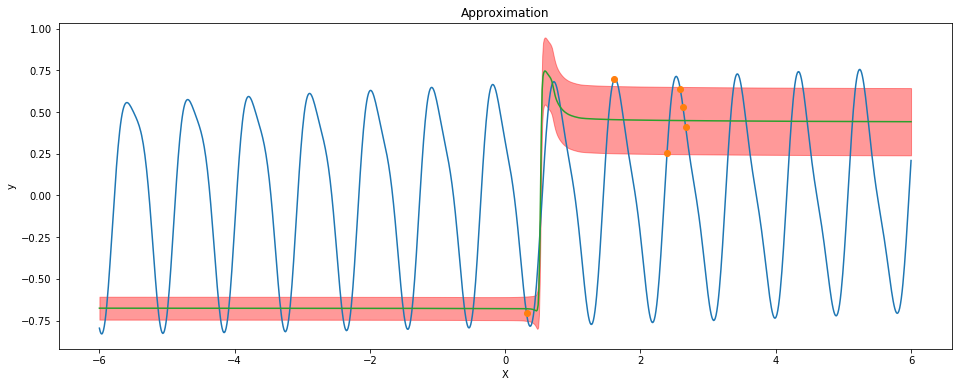

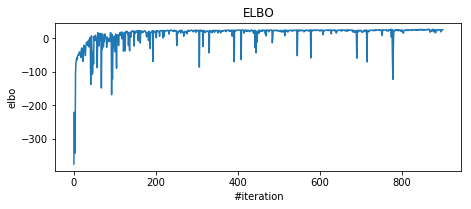

In [109]:
datasets, param_set = generate_dataset(1) #Size=50
verbose = False
X_0, y_0 = train_model(model, num_epochs=1000, batchsize = 50)

# Test

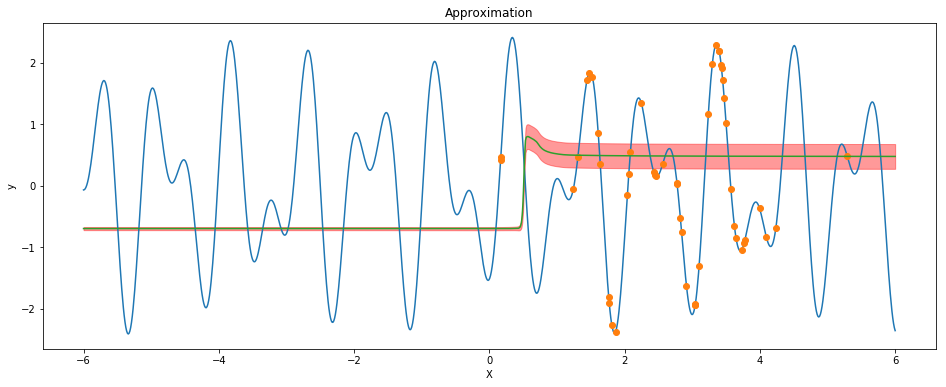

In [110]:
test_set, test_param = generate_dataset(1, Size=50)
verbose = False
plot_f(test_param, test_set[0])

# Let implement some flows to enrich our posterior destribution $q(z|x)$

# Planar Flow
https://arxiv.org/pdf/1505.05770.pdf

Flow:

$$z_t = z_{t-1} + uh(w^Tz_{t-1} + b)$$ 

ELBO:

$$ -ELBO = E_{q(z|x)} [\ln q(z|x) − \ln p(x | z)-\ln p(z)]  \\
= E_{q_0(z_0)} [\ln q_K(z_K) − \ln p(x | z_K)-\ln p(z_K)] \\
= E_{q_0(z_0)}[\ln q_0(z_0)] − E_{q_0(z_0)}[\ln p(x | z_K)]-\ln p(z_K)
− E_{q_0(z_0)} \sum_{k=1}^K \ln |1 + u_k \phi_k(z_{k−1})| 
$$

where $\phi(z) = h(w^Tz + b)w$

## Model 

In [111]:
class Flow_Planar(nn.Module):
    def __init__(self, dim_in):
        """ 
        nn that model distribution of latent z by flactuating it     
        """
        super(Flow_Planar, self).__init__()
        
        # пока самая простая 
        self.w = nn.Linear(dim_in, 1)
        self.h = nn.Tanh()
        self.u = nn.Linear(1, dim_in, bias=False)
            
        
    def forward(self, z):
        """
        takes latent z and produces next latent z
        """
        
        pre_phi = self.h(self.w(z))
        z_new = z+self.u(pre_phi)
        phi = pre_phi@self.w.weight
        
        return z_new, phi

In [112]:
class DeepPrior_Planar(nn.Module):
    def __init__(self, in_x, in_z, dim_middle, dim_out, n_enc_layers, n_dec_layers, n_flow_layers):
        
        super(DeepPrior_Planar, self).__init__()
    
        self.dim_z = in_z
        
        in_y = 1
        self.in_z = in_z
        
        self.encoder = Encoder(in_x+in_y, self.in_z, self.in_z, n_enc_layers)
        self.flow_stack = nn.ModuleList([ Flow_Planar(self.in_z) for _  in range(n_flow_layers) ])
        self.decoder = Decoder(in_z, in_x, dim_middle, dim_out, n_dec_layers)
        
        self.ELBO = {}
 
    def forward(self, ind, X, y, l):
        """
        takes dataset S and produces ELBO lower bound for p(D) where D - dataset
        """
        
        # now let compute stohastic part
        S = torch.cat([X, y], dim = -1)
        if verbose: print('S', S.shape)
        mu_z, sigma_z, s_z = self.encoder(S)
        if verbose: print('mu_z, sigma_z', mu_z.shape, sigma_z.shape)
        sigma_z = sigma_z.pow(1/2)
            
        #sampling
        N_batch = S.shape[0]
        z = torch.normal(mean = torch.zeros((1, self.in_z)), 
                          std = torch.ones((1,  self.in_z)))
            
        z = mu_z+sigma_z*z
        if verbose: print('z', z.shape)
             
            
        #flow part     
        flow_loss = - 1/2* s_z.sum()
        if verbose: print('flow_loss', flow_loss)
            
#         print('flow_loss', flow_loss)
        
        for flow in self.flow_stack:
            z, phi = flow(z)   
            
            flow_loss = flow_loss - (1+ phi @ flow.u.weight ).abs().log().sum()
            print('pre_phi', phi.sum())
            print('flow_loss', (1+ phi @ flow.u.weight ).abs().log().sum())
            
        if verbose: print('flow_loss2', flow_loss)
#         flow_loss = flow_loss.sum()    
        
        #prior part 
        prior_loss = -1/2*(z*z).sum()
        
        z = z.repeat(N_batch, 1)
        
        if verbose: print('z', z.shape)
            
        mu_y, sigma_y = self.decoder(X, z)
        
        if verbose: print('mu_y, sigma_y', mu_y.shape, sigma_y.shape)
        
        
        log_likelihood = -1/2*(y - mu_y)*(y-mu_y)/ sigma_y.pow(2)
        if verbose: print('log_likelihood', log_likelihood.shape) 
        
        log_likelihood = log_likelihood.sum()-sigma_y.log().mean()
        if verbose: print('log_likelihood', log_likelihood.shape)

        loss = log_likelihood+flow_loss+prior_loss
        
        l_np = float(loss.cpu().data.numpy())
#         print('l_np',l_np)n
        try:
            self.ELBO[ind].append(l_np)
        except KeyError:
            self.ELBO[ind]=[l_np]

        print('loss', loss)
        return -loss
    
    def predict(self, X, y, X_pred):
        """
        S - dataset (tuple with two tensors with shape (Points, 1))
        X - points to predict y in (tensor with shape (N_points, ))
        """
        
        S = torch.cat([X, y], dim = -1)
        if verbose: print('S', S.shape)
        mu_z, sigma_z, _  = self.encoder(S)
            
        z = mu_z.unsqueeze(0) #+sigma_z*z
        
        for flow in self.flow_stack:
            z, _ = flow(z)   
                 
        if verbose: print('z', z.shape)
            
        z = z.repeat(X_pred.shape[0], 1)
        if verbose: 
            print('z', z.shape)
            print('X', X.shape)
            
        mu_y, sigma_y = self.decoder(X_pred, z)
        
        return mu_y, sigma_y

        

# Training

In [113]:
# оптимайзер
from torch import optim
from itertools import chain
model = DeepPrior_Planar(in_x=1, in_z=32, dim_middle=128, dim_out=1, n_enc_layers=4, n_dec_layers=4, 
                         n_flow_layers=12)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [114]:
# datasets, param_set = generate_dataset(2) #Size=50
# verbose = False
# X_0, y_0 = train_model(model, num_epochs=10000, batchsize = 50, verbose=False)

# Test

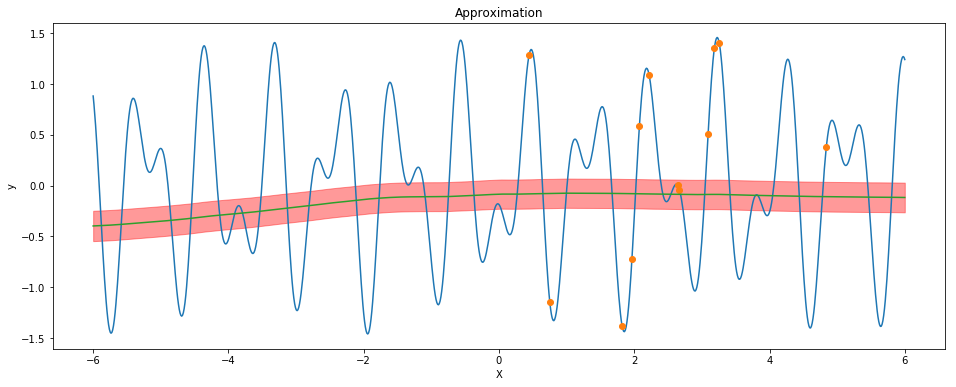

In [115]:
test_set, test_param = generate_dataset(1, Size=12)
verbose = False
plot_f(test_param, test_set[0])

# Inverse Autoregressive Flow
https://arxiv.org/pdf/1606.04934.pdf

Flow in gereral:

$$z_t = \mu_t + \sigma_t \odot z_{t−1}$$

Particulary (our case):

$$[\mu_t, s_t] = AutoregressiveNN[t](z_{t-1}, h; \theta)$$

$$\sigma_t = Sigmoid(s_t)$$

$$z_t = \sigma_t \odot z_{t−1} + (1 − \sigma_t) \odot \mu_t$$

ELBO:

$$ -ELBO = E_{q(z|x)} [\ln q(z|x) − \ln p(x | z)- \ln p(z) ] \\
= E_{q_0(z_0)} [\ln q_K(z_K) − \ln p(x | z_K)- \ln p(z_K)]  \\
= E_{q_0(z_0)}[\ln q_0(z_0)] − E_{q_0(z_0)}[\ln p(x | z_K)]- \ln p(z_K)
- E_{q_0(z_0)} \sum_{k=1}^K \sum_i  \log \sigma_{ki} = \\
− E_{q_0(z_0)}[\ln p(x | z_K)]- \ln p(z_K)
- E_{q_0(z_0)} \sum_{k=0}^K \sum_i  \log \sigma_{ki}+ const
$$

as 
$$\ln q_K(z_k)= \ln q(z_0|x) - \sum_t \ln \det \frac{dz_t} {dz_{t−1}} = \ln q(z_0|x)  - \sum_t \ln \det \sigma_t
$$ 

for one update of $z$

$$
\ln p(z_K) = -\frac 1 2 (z_K^Tz_K + D \ln(2\pi))
$$

$$
\ln p(z_0 | x) = -\frac 1 2 (\epsilon^T\epsilon + D \ln(2\pi))- \sum_i \ln \sigma_{0i}
$$

where $D$ is dimention of $z$


## Model 

In [243]:
from torch.nn.init import xavier_normal
from torch.nn.parameter import Parameter
import math

class AutoregressiveLinear(nn.Module):
    def __init__(self, in_size, out_size, bias=True, ):
        super(AutoregressiveLinear, self).__init__()

        self.in_size = in_size
        self.out_size = out_size

        self.weight = Parameter(torch.Tensor(self.in_size, self.out_size))

        if bias:
            self.bias = Parameter(torch.Tensor(self.out_size))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self, ):
        stdv = 1. / math.sqrt(self.out_size)

        self.weight = xavier_normal(self.weight)

        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        if input.dim() == 2 and self.bias is not None:
            return torch.addmm(self.bias, input, self.weight.tril(-1))

        output = input @ self.weight.tril(-1)
        if self.bias is not None:
            output += self.bias
        return output
    
class Flow_IAF(nn.Module):
    def __init__(self, latent_size, h_size):
        super(Flow_IAF, self).__init__()

        self.z_size = latent_size
        self.h_size = h_size

        self.m = nn.Sequential(
            AutoregressiveLinear(self.z_size + self.h_size, self.z_size),
            nn.ELU(),
            AutoregressiveLinear(self.z_size, self.z_size),
            nn.ELU(),
            AutoregressiveLinear(self.z_size, self.z_size)
        )

        self.s = nn.Sequential(
            AutoregressiveLinear(self.z_size + self.h_size, self.z_size),
            nn.ELU(),
            AutoregressiveLinear(self.z_size, self.z_size),
            nn.ELU(),
            AutoregressiveLinear(self.z_size, self.z_size)
        )

    def forward(self, z, h):
        """
        :param z: An float tensor with shape of [batch_size, z_size]
        :param h: An float tensor with shape of [batch_size, h_size]
        :return: An float tensor with shape of [batch_size, z_size] and log det value of the IAF mapping Jacobian
        """

#         h = self.h(h)

        N_batch = z.shape[0]
        h = h.repeat(N_batch, 1)
        
        input = torch.cat([z, h], 1)

        self.mu_z  = self.m(input)
        s = self.s(input+2)
        
        self.sigma_z = nn.Sigmoid()(s)
        
        z = self.sigma_z*z+(1-self.sigma_z)*self.mu_z 

        return z, s
    
    
class Encoder(nn.Module):
    def __init__(self, dim_in, dim_middle, dim_out, n_layers):
        """ 
        nn that maps dataset to the latent z that represent it      
        """
        super(Encoder, self).__init__()
        
        
        # пока самая простая 
        self.fc1 = nn.Linear(dim_in, dim_middle)
        self.relu = nn.ELU()
        
        self.mu = nn.Sequential(
            nn.Linear(dim_middle, dim_out),
            nn.ELU(),
            nn.Linear(dim_middle, dim_middle),
            nn.ELU(),
            nn.Linear(dim_middle, dim_out)
        )
        
        self.sigma = nn.Sequential(
            nn.Linear(dim_middle, dim_out),
            nn.ELU(),
            nn.Linear(dim_middle, dim_middle),
            nn.ELU(),
            nn.Linear(dim_middle, dim_out)
        )
        
        self.hid = nn.Sequential(
            nn.Linear(dim_middle, dim_out),
            nn.ELU(),
            nn.Linear(dim_middle, dim_middle),
            nn.ELU(),
            nn.Linear(dim_middle, dim_out)
        )
                  
 
    def forward(self, S):
        """
        takes dataset S and produces mu and sigma of normal distribution z
        """

        S = self.relu(self.fc1(S))  
        
        if verbose: print('S', S.shape)
        S = S.mean(0)
        
        self.mu_z = self.mu(S)
        self.s = self.sigma(S)-100
        self.sigma_z = self.s.exp() # экспонента чтобы не было отрицательных значений дисперсии
        self.h = self.hid(S)

        return self.mu_z, self.sigma_z,  self.s,  self.h
    

                


In [244]:
class DeepPrior_IAF(nn.Module):
    def __init__(self, in_x, in_z, dim_middle, dim_out, n_enc_layers, n_dec_layers, n_flow_layers):
        
        super(DeepPrior_IAF, self).__init__()
    
        self.dim_z = in_z
        
        in_y = 1
        self.in_z = in_z
        self.n_IAF_layers = 2
        
        self.encoder = Encoder(in_x+in_y, self.in_z, self.in_z, n_enc_layers)
        self.flow_stack = nn.ModuleList([ Flow_IAF(self.in_z, self.in_z) for _  in range(n_flow_layers) ])
        self.decoder = Decoder(in_z, in_x, dim_middle, dim_out, n_dec_layers)
        
        self.ELBO = {}
 
    def forward(self, ind, X, y, l):
        """
        takes dataset S and produces ELBO lower bound for p(D) where D - dataset
        """
        
        # now let compute stohastic part
        S = torch.cat([X, y], dim = -1)
        if verbose: print('S', S.shape)
        mu_z, sigma_z, s_z, h = self.encoder(S)
        if verbose: print('mu_z, sigma_z', mu_z.shape, sigma_z.shape)
        sigma_z = sigma_z.pow(1/2)
            
        #sampling
        N_batch = S.shape[0]
        z = torch.normal(mean = torch.zeros((1, self.in_z)), 
                          std = torch.ones((1,  self.in_z)))
        
            
        z = mu_z+sigma_z*z
        if verbose: print('z', z.shape)
            
        #flow part     
        flow_loss = 0 #1/2* s_z.sum()
    
        z0_loss = 1/2* s_z.sum() #1/2* s_z.sum() #torch.zeros(1).sum() # 1/2* s_z.sum()
        
        for flow in self.flow_stack:
            z, s = flow(z, h)   
            flow_loss = flow_loss + nn.LogSigmoid()(s).sum()
         
        
#         print('flow_loss2', flow_loss)
        #prior part         
        prior_loss = -1/2*(z*z).sum()
        
        z = z.repeat(N_batch, 1)
        
        if verbose: print('z', z.shape)
        
        mu_y, sigma_y = self.decoder(X, z)
        
        if verbose: print('mu_y, sigma_y', mu_y.shape, sigma_y.shape)
        
        
        log_likelihood = -1/2*(y - mu_y)*(y-mu_y)/ sigma_y.pow(2)
        if verbose: print('log_likelihood', log_likelihood.shape) 
            
        log_likelihood = log_likelihood.sum()-sigma_y.log().mean()
        if verbose: print('log_likelihood', log_likelihood.shape)

        loss = log_likelihood+(flow_loss+prior_loss)+z0_loss
        
        l_np = float(loss.cpu().data.numpy())
        try:
            self.ELBO[ind].append(l_np)
        except KeyError:
            self.ELBO[ind]=[l_np]

        
        return -loss, log_likelihood, flow_loss, prior_loss, z0_loss
    
    def predict(self, X, y, X_pred):
        """
        S - dataset (tuple with two tensors with shape (Points, 1))
        X - points to predict y in (tensor with shape (N_points, ))
        """
        
        S = torch.cat([X, y], dim = -1)
        if verbose: print('S', S.shape)
        mu_z, sigma_z, _, h = self.encoder(S)
            
        z = mu_z.unsqueeze(0) #+sigma_z*z
        
        for flow in self.flow_stack:
            z, _ = flow(z, h)   
                 
        if verbose: print('z', z.shape)
            
        z = z.repeat(X_pred.shape[0], 1)
        if verbose: 
            print('z', z.shape)
            print('X', X.shape)
            
        mu_y, sigma_y = self.decoder(X_pred, z)
        
        return mu_y, sigma_y

        

# Training

In [253]:
# оптимайзер
from torch import optim
from itertools import chain
model = DeepPrior_IAF(in_x=1, in_z=128, dim_middle=128, dim_out=1, n_enc_layers=0, n_dec_layers=4, 
                         n_flow_layers=12)
optimizer = optim.Adam(model.parameters(), lr=0.001)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


Epoch 1 of 10000 took 1540483380.133s
current elbo: -18610.333984375
losses [-1410.4899] [-128.44371] [-1.6530781] [-5443.4014]


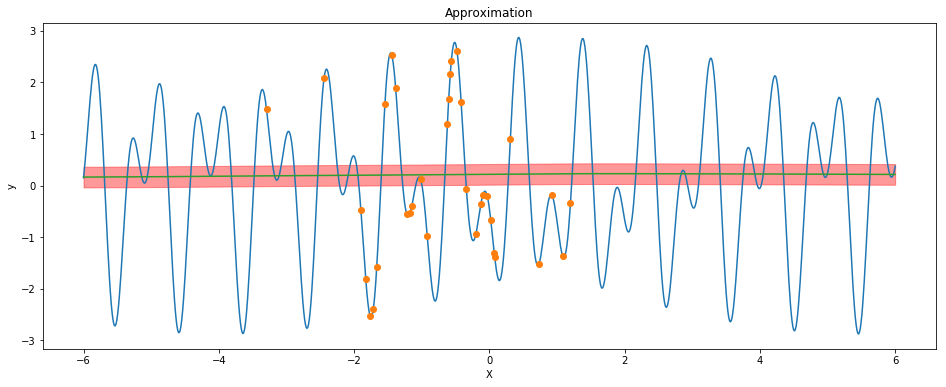

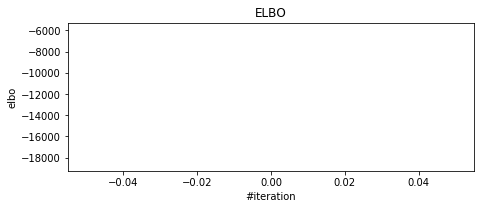

In [ ]:
datasets, param_set = generate_dataset(50, Size=None) #Size=50
verbose = False
X_0, y_0 = train_model(model, num_epochs=10000, batchsize = 50, verbose=True)

# Test

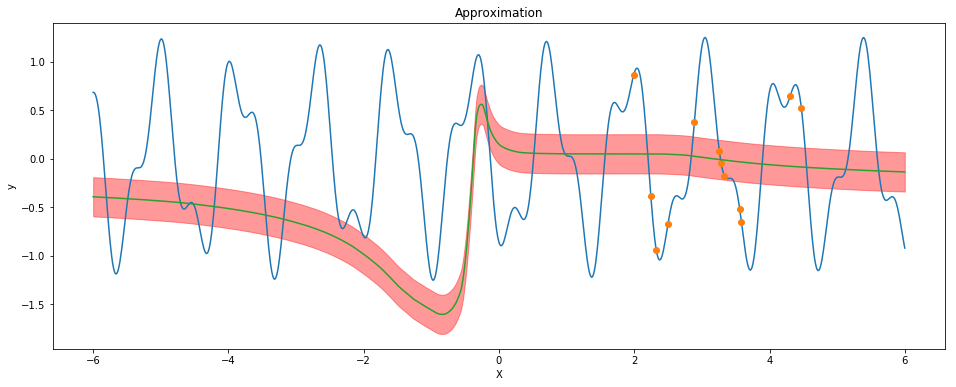

In [251]:
test_set, test_param = generate_dataset(1, Size=12)
verbose = False
plot_f(test_param, test_set[0])